## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Save the calibration matrix and distortion coefficients

import pickle
%matplotlib notebook



img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = img.shape[0:2]

print(img_size)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undist = cv2.undistort(img, mtx, dist, None, mtx)

#save the calibration results
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/dist_pickle.p", "wb"))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

# Load and test distortion and warp perspective

True


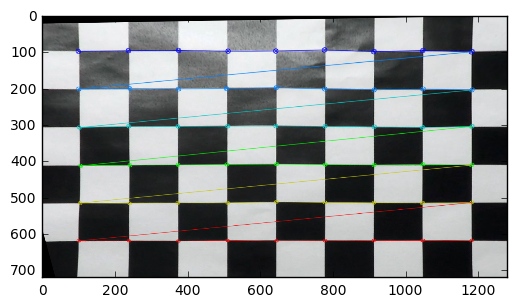

In [16]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open( "./camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('./camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print(ret)
    warped = None
    M = None
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

warped_img, M = corners_unwarp(img, nx, ny, mtx, dist)

plt.imshow(warped_img)




In [74]:
import glob
image_files = glob.glob('./test_images/*.jpg')

images = []
for fname in image_files:
    img = cv2.imread(fname)
    images.append(img)
    
print(len(images))

image = images[0]

8


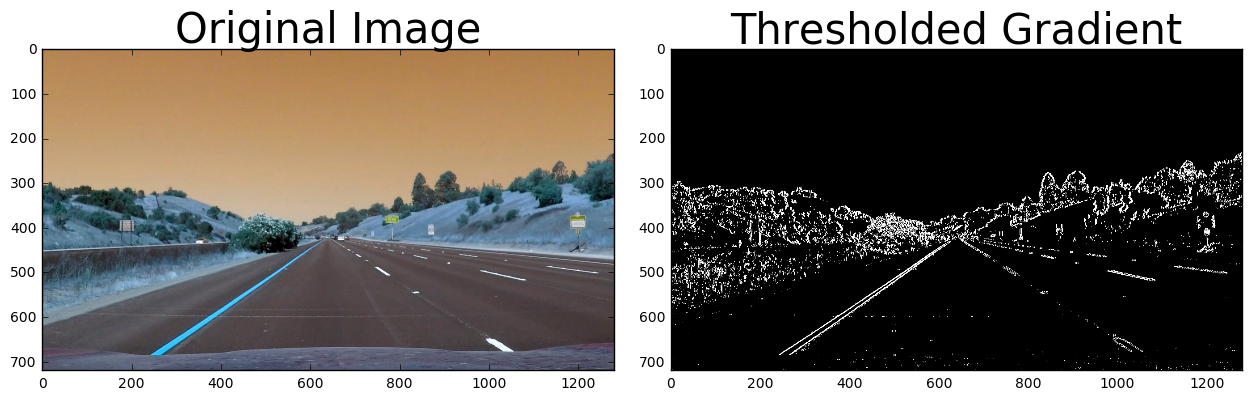

In [18]:
%matplotlib inline

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

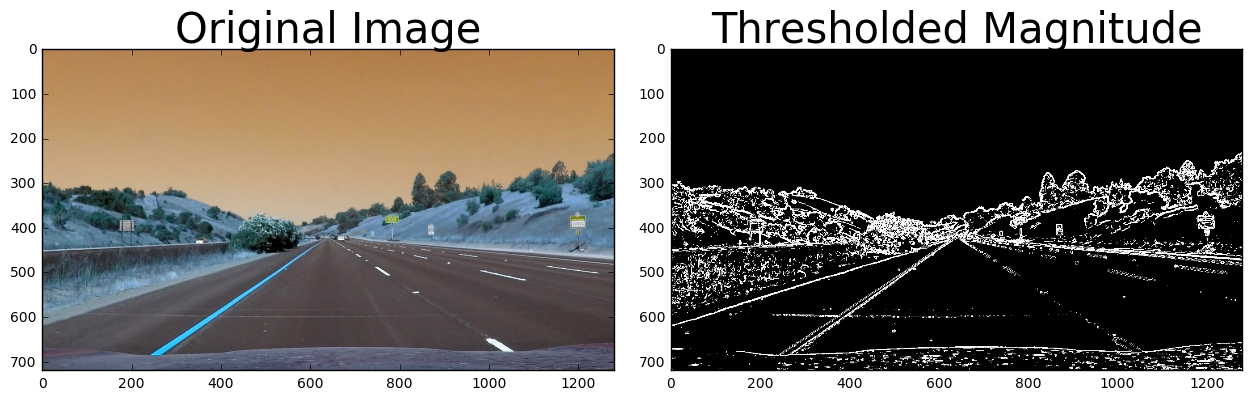

In [19]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_mag)
    sxbinary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
# print(mag_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

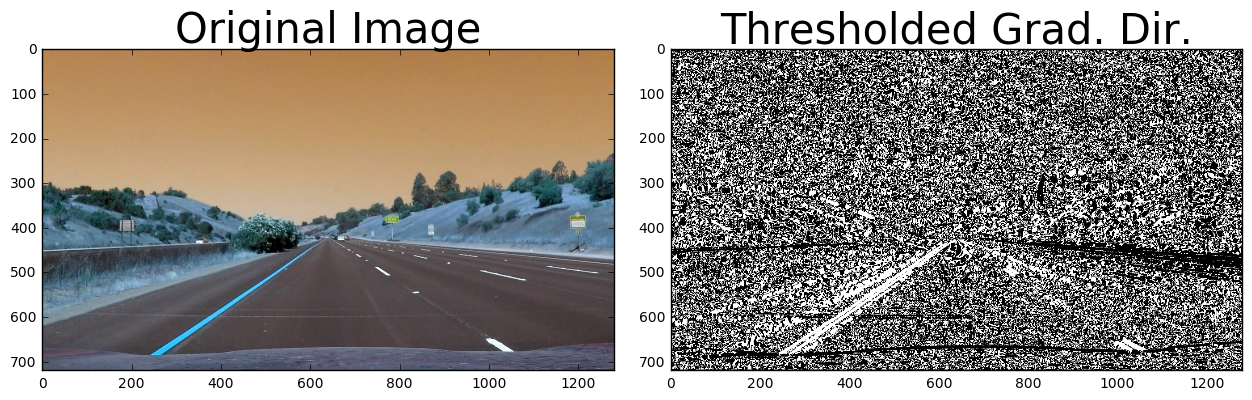

In [20]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    G = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(G)
    mask[(G > thresh[0]) & (G < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

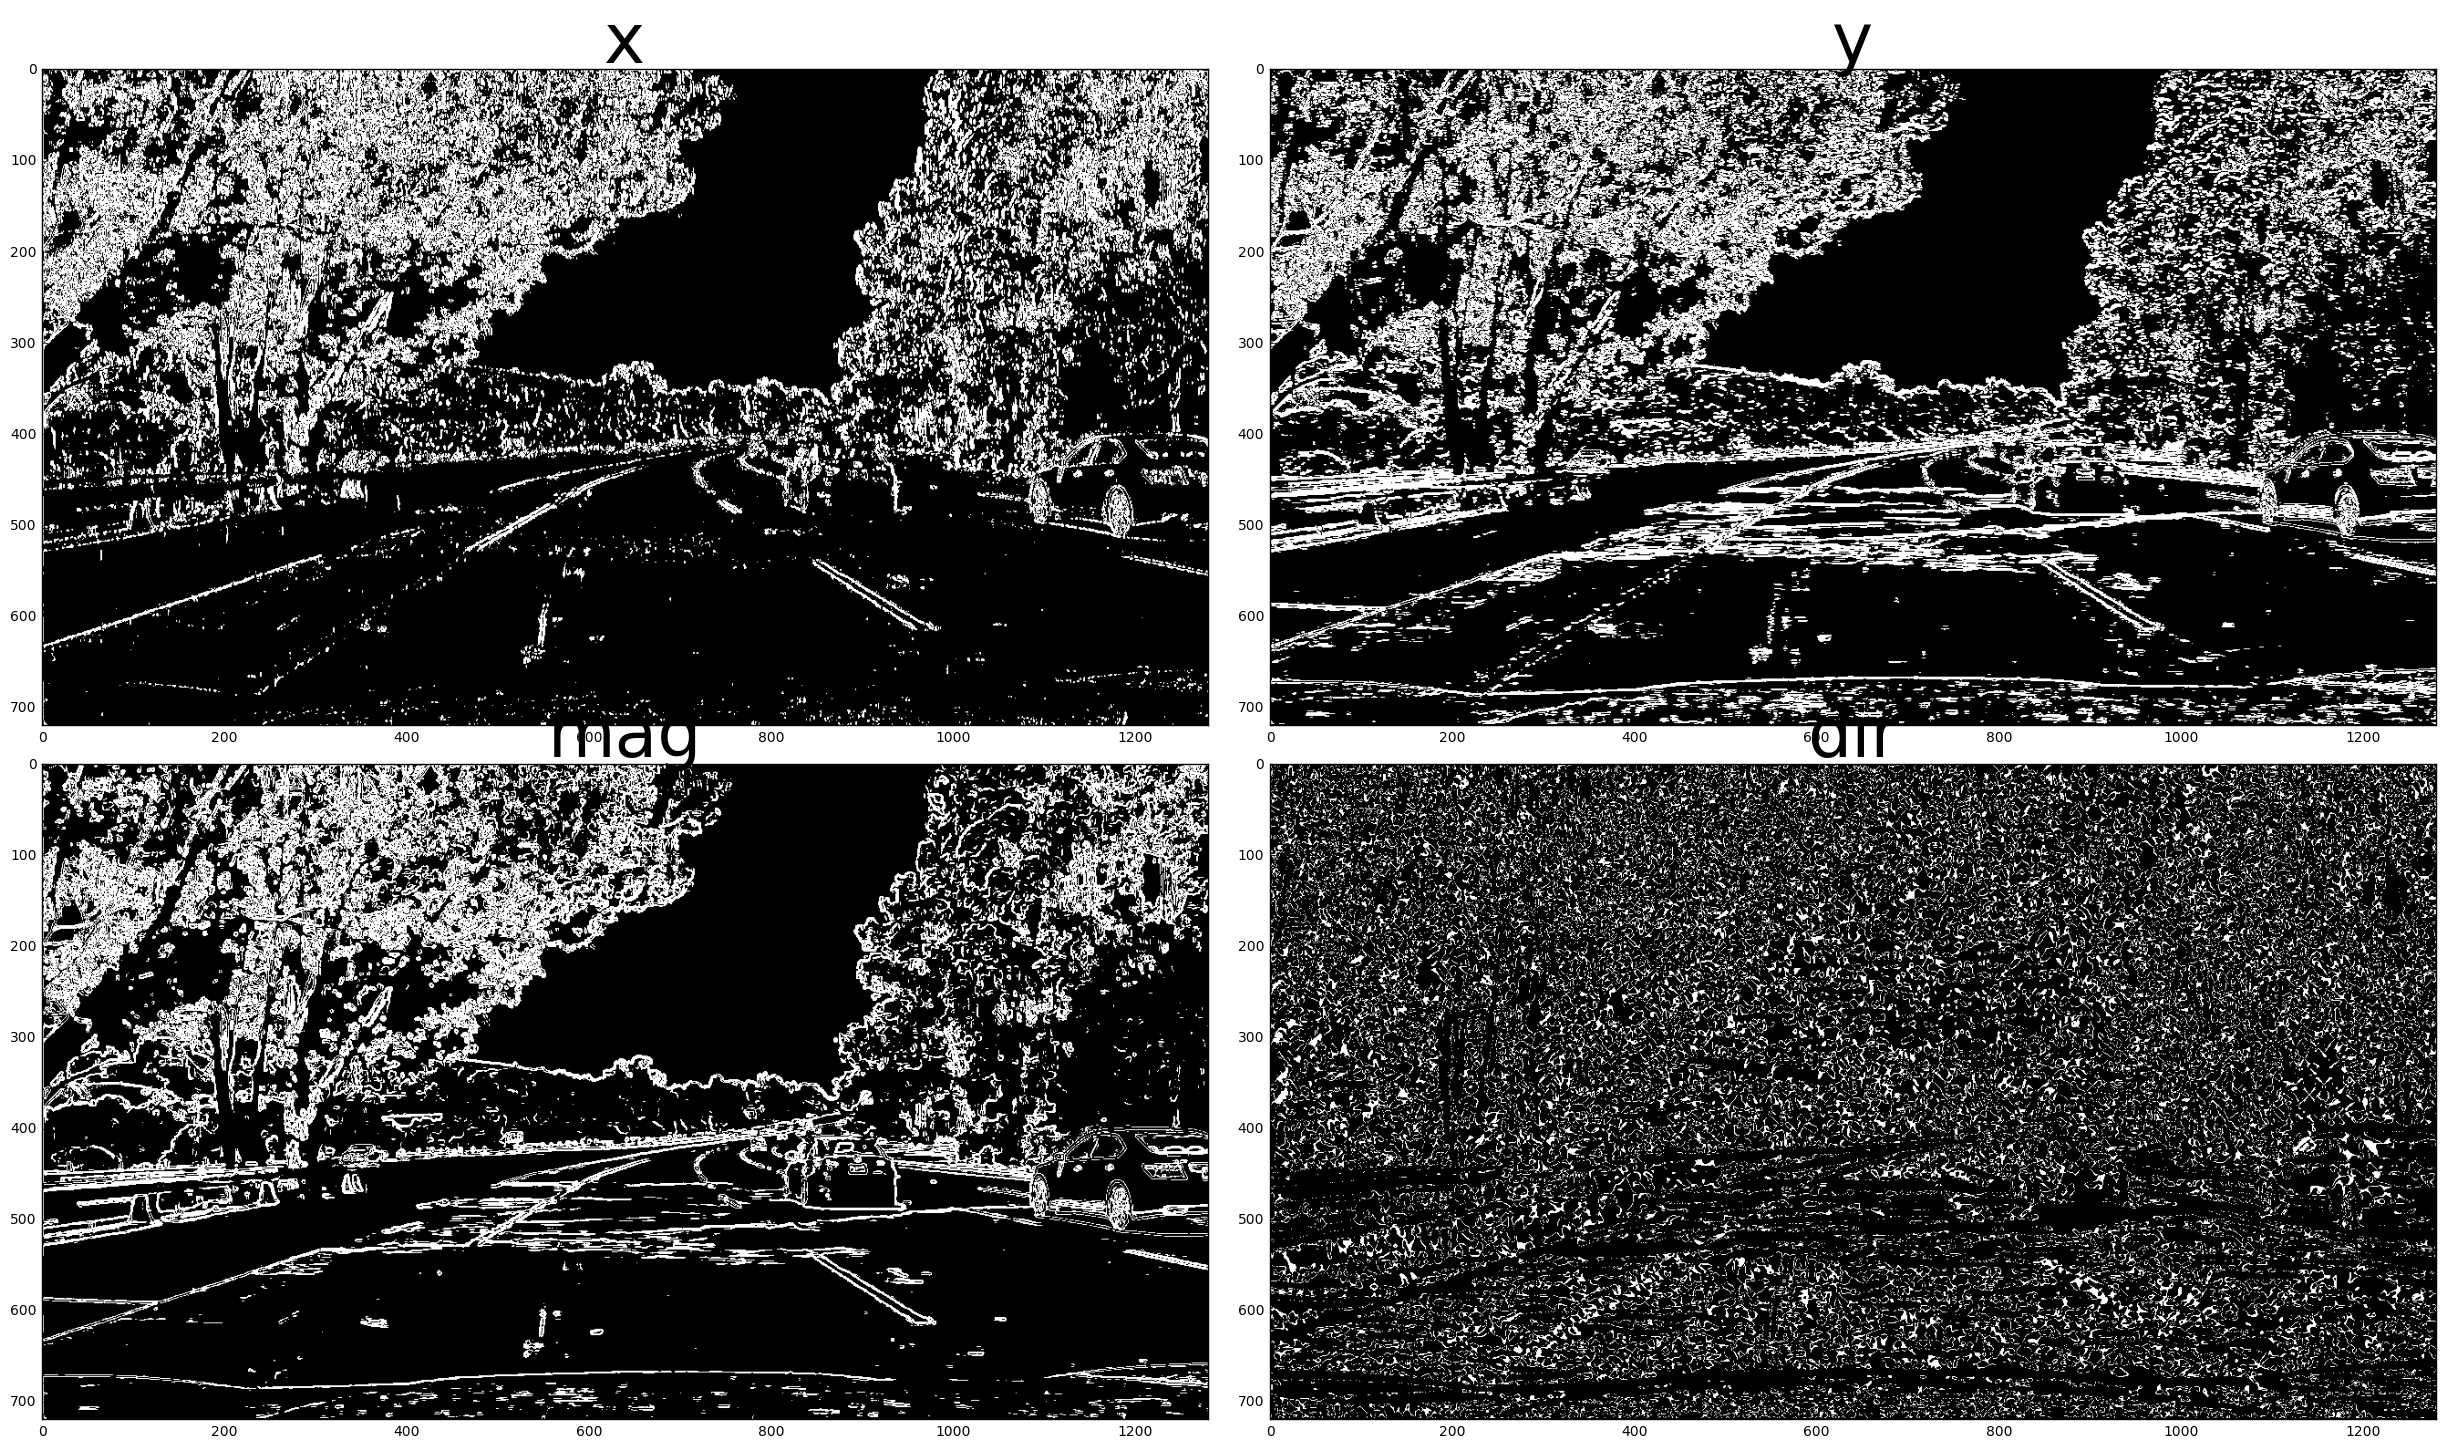

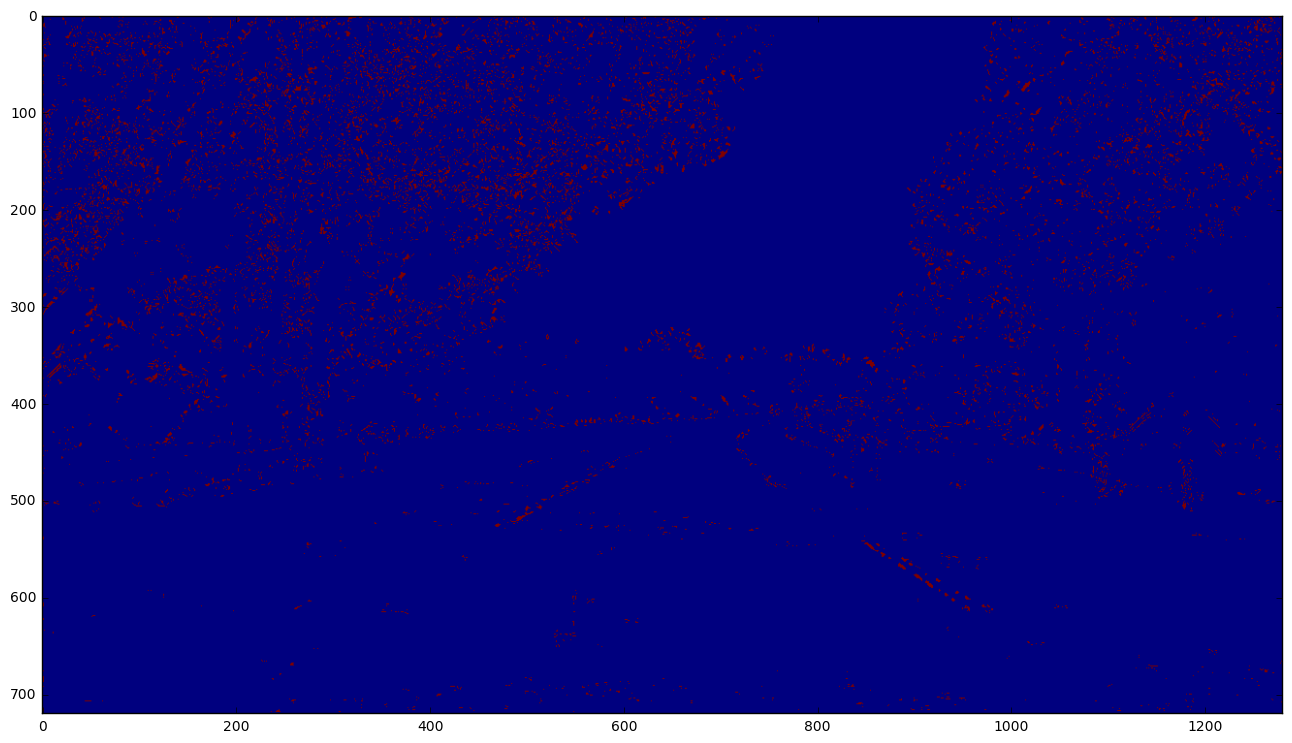

In [21]:
# Look into 
# https://github.com/abidrahmank/OpenCV2-Python/blob/master/Official_Tutorial_Python_Codes/3_imgproc/laplacian.py
# Canny Edge Detector
# http://opencvpython.blogspot.com.au/2012/06/image-derivatives-sobel-and-scharr.html


%matplotlib inline

image = images[6]

x_grad_binary = abs_sobel_thresh(image, orient='x', thresh=(10, 100))
y_grad_binary = abs_sobel_thresh(image, orient='y', thresh=(10, 100))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))

f, ax = plt.subplots(2, 2, figsize=(24, 15))
f.tight_layout()
ax[0][0].imshow(x_grad_binary, cmap='gray')
ax[0][0].set_title('x', fontsize=50)
ax[0][1].imshow(y_grad_binary, cmap='gray')
ax[0][1].set_title('y', fontsize=50)

ax[1][0].imshow(mag_binary, cmap='gray')
ax[1][0].set_title('mag', fontsize=50)
ax[1][1].imshow(dir_binary, cmap='gray')
ax[1][1].set_title('dir', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


binary = np.zeros_like(dir_binary)
binary[(dir_binary == 1) & (mag_binary == 1)] = 1

plt.figure(2)
f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(binary)




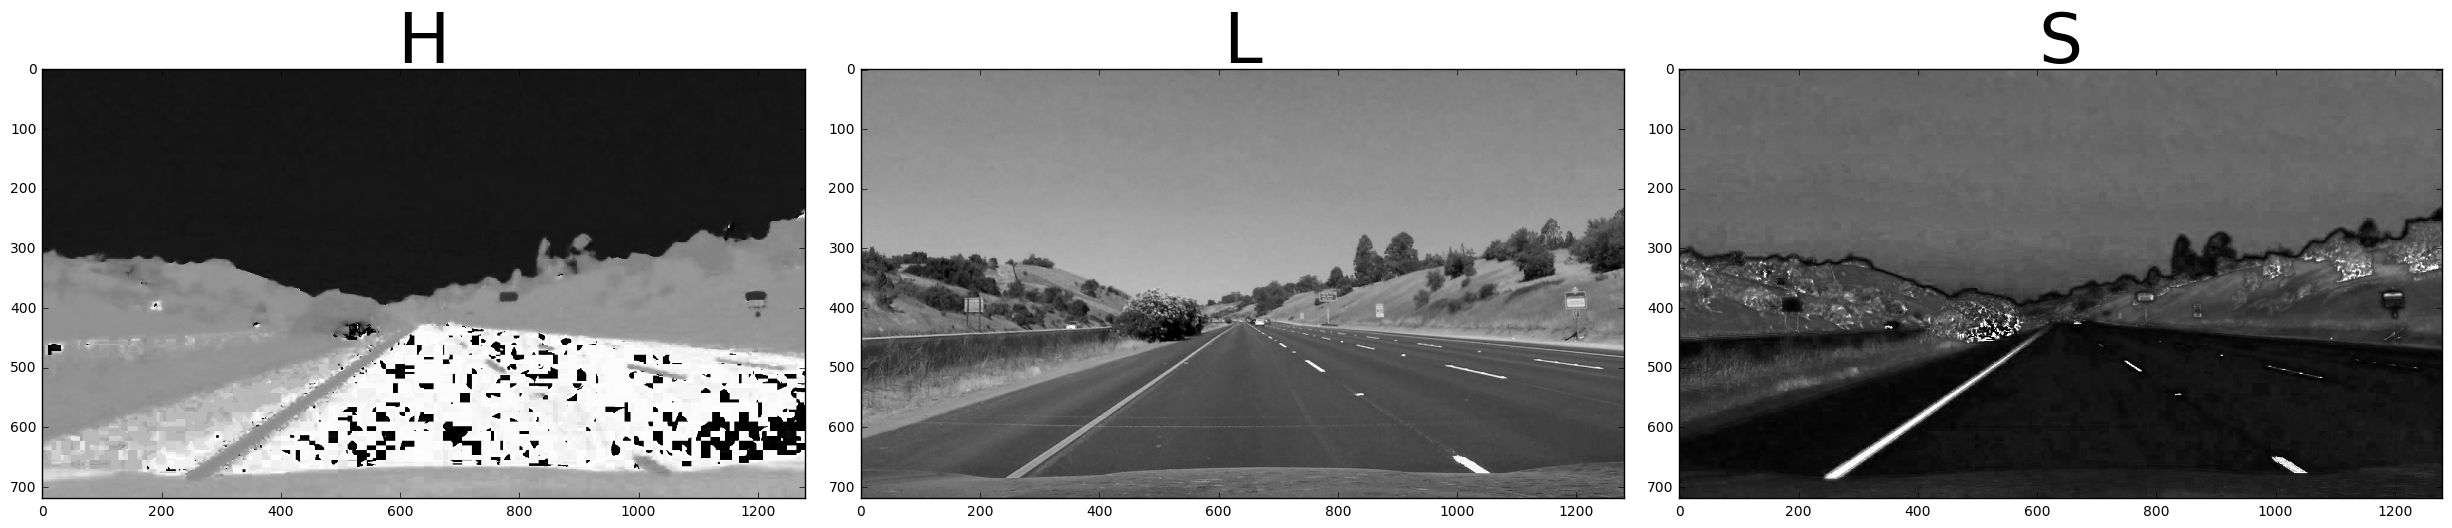

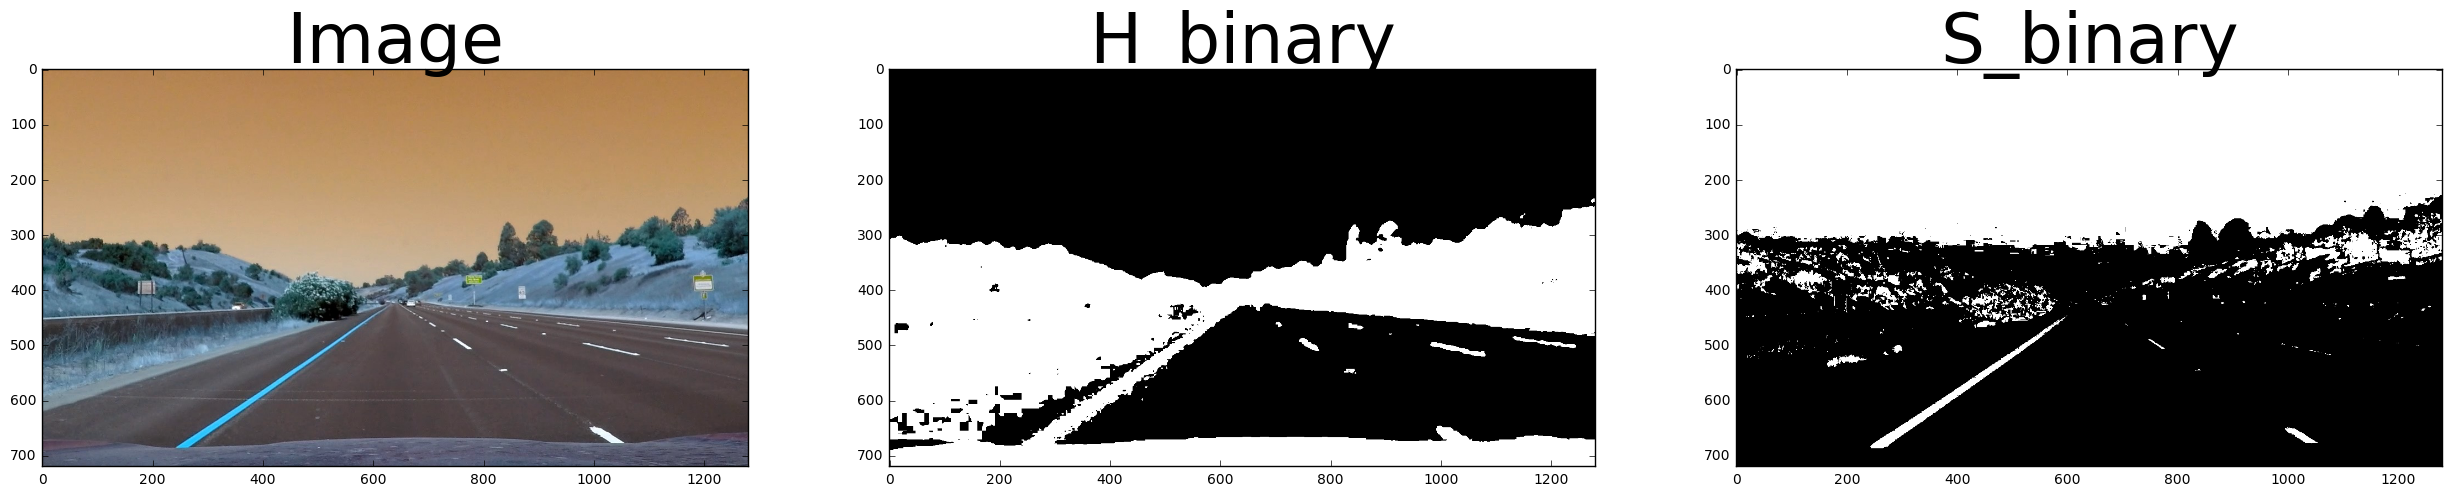

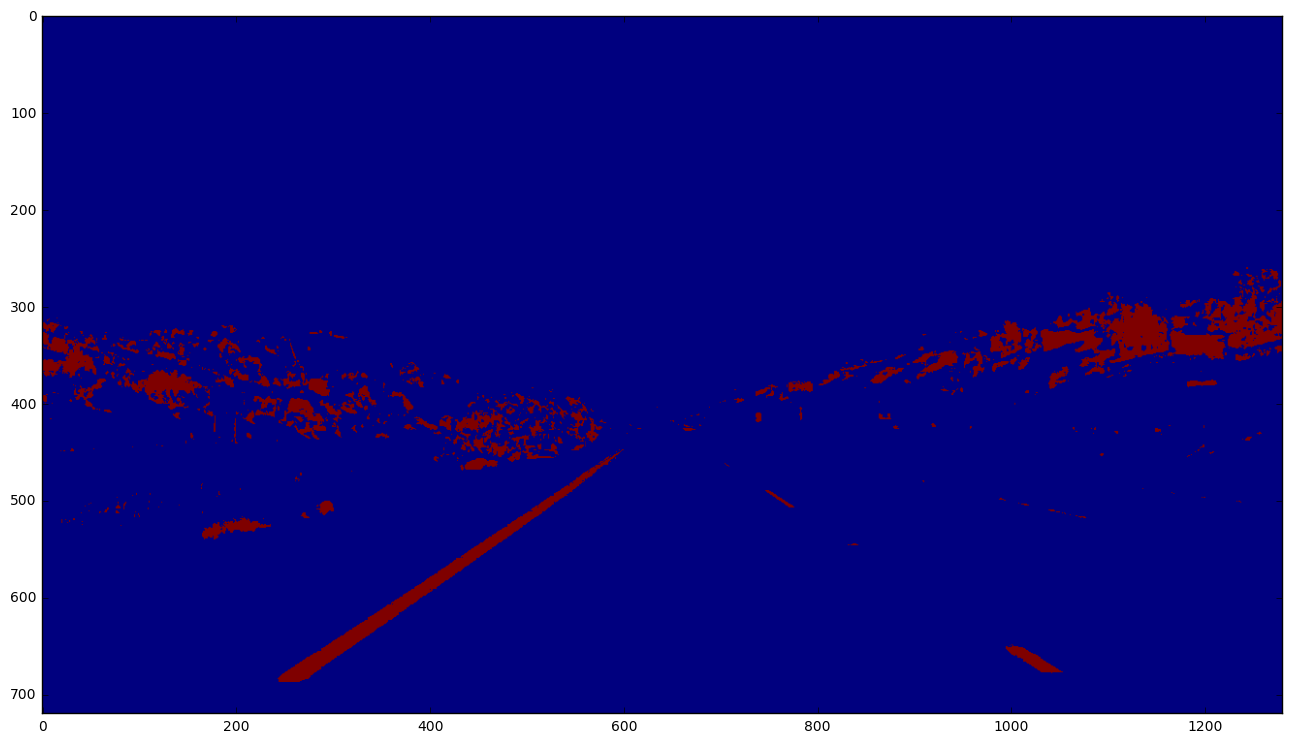

In [109]:
%matplotlib inline

image = images[0]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(1)

H_thresh = (30, 140)
H_binary = np.zeros_like(H)
H_binary[(H > H_thresh[0]) & (H <= H_thresh[1])] = 1

S_thresh = (90, 255)
S_binary = np.zeros_like(S)
S_binary[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.imshow(image, cmap='gray')
ax1.set_title('Image', fontsize=50)
ax2.imshow(H_binary, cmap='gray')
ax2.set_title('H_binary', fontsize=50)
ax3.imshow(S_binary, cmap='gray')
ax3.set_title('S_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


binary = np.zeros_like(S)
binary[(S_binary == 1) & (H_binary == 1)] = 1
plt.figure(2)
f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(binary)

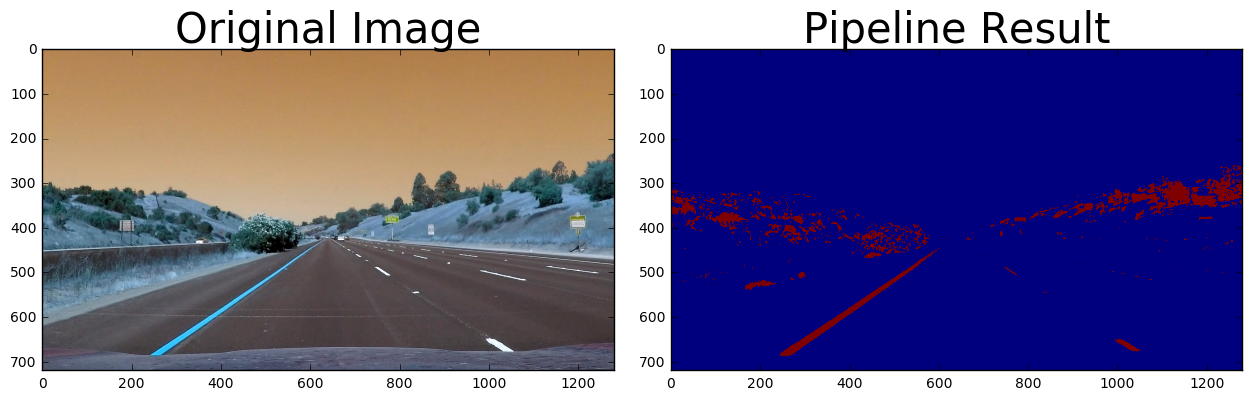

In [110]:
%matplotlib inline

image = images[0]

def hsl_channel_threshold(img, s_thresh=(170, 255), h_thresh=(30, 140)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    binary = np.zeros_like(h_channel)
    binary[(s_binary == 1) & (h_binary == 1)] = 1
    return binary
    
result = hsl_channel_threshold(image, s_thresh=(90, 255), h_thresh=(30, 140))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

C:\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


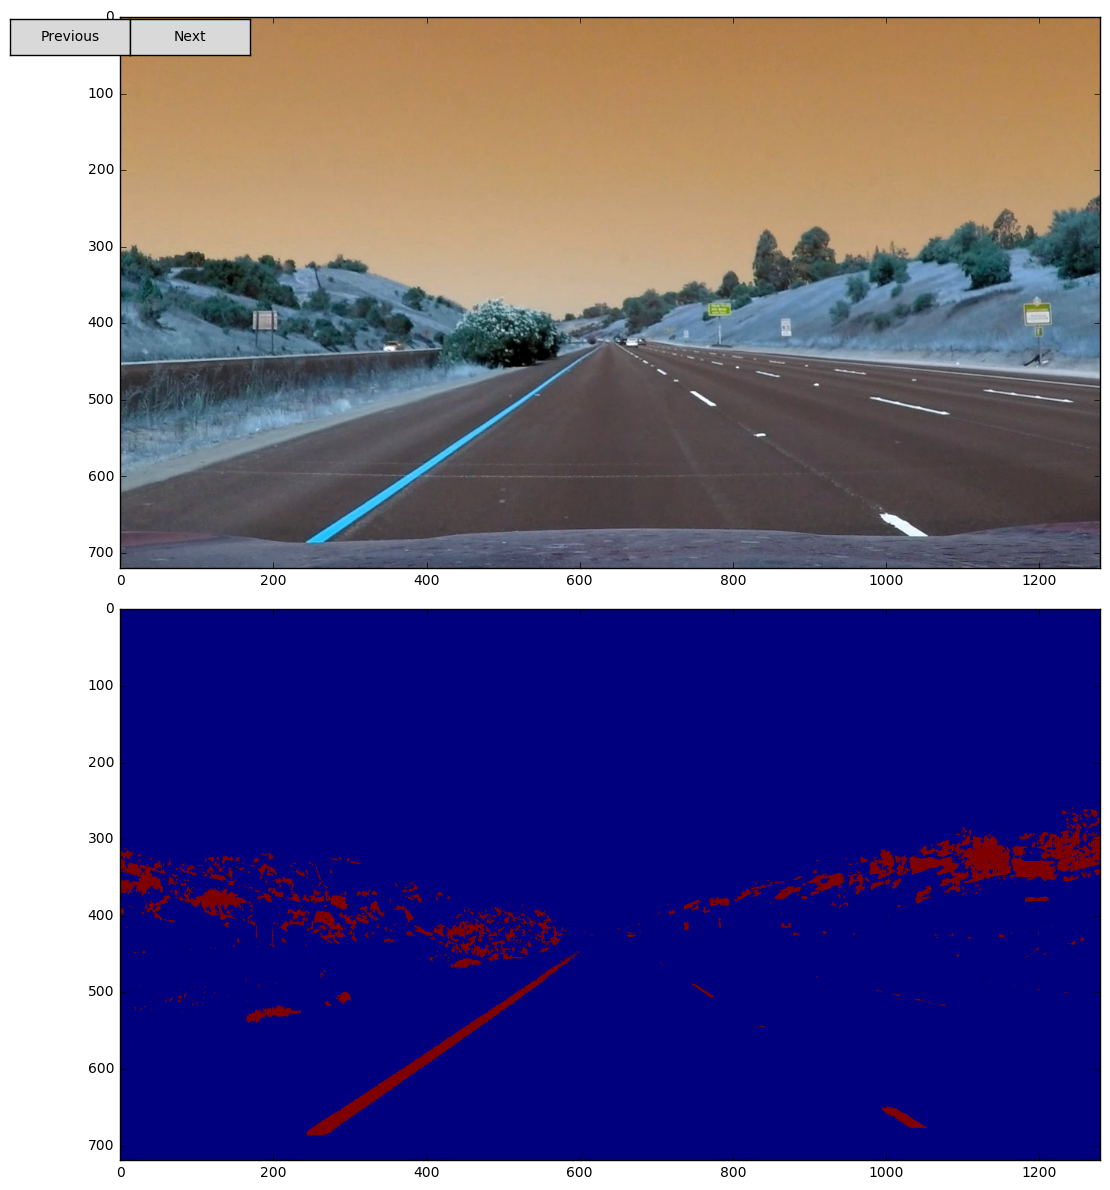

In [111]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# fig_size = plt.rcParams["figure.figsize"]
# print(fig_size)
# plt.rcParams['figure.figsize'] = (20.0, 10.0)

image = images[0]
def filter_lanes(image):
    x_grad_binary = abs_sobel_thresh(image, orient='x', thresh=(10, 100))
    y_grad_binary = abs_sobel_thresh(image, orient='y', thresh=(10, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.0))
    hsl_channel_binary = hsl_channel_threshold(image, s_thresh=(90, 255), h_thresh=(30, 140))

    combined = np.zeros_like(dir_binary)
#     combined[(x_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1) & (x_grad_binary == 1)] = 1
#     combined[(mag_binary == 1)] = 1
#     combined[(dir_binary == 1)] = 1
    combined[(hsl_channel_binary == 1)] = 1
#     combined[(dir_binary == 1) & (hsl_channel_binary == 1)] = 1
    return combined



figure, ax = plt.subplots(2, figsize=(12,12))
i1 = ax[0].imshow(images[0])
i2 = ax[1].imshow(filter_lanes(images[0]))

class Index(object):
    ind = 0
    length = 0
    def __init__(self, length):
        self.length = length
    
    def next(self, event):
        self.ind += 1
        if self.ind >= self.length:
            self.ind = 0
        ax[0].imshow(images[self.ind])
        ax[1].imshow(filter_lanes(images[self.ind]))

    def prev(self, event):
        self.ind -= 1
        if self.ind < 0:
            self.ind = self.length - 1
        ax[0].imshow(images[self.ind])
        ax[1].imshow(filter_lanes(images[self.ind]))

callback = Index(len(images))
axprev = plt.axes([0, 0.95, 0.1, 0.03])
axnext = plt.axes([0.1, 0.95, 0.1, 0.03])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.tight_layout()

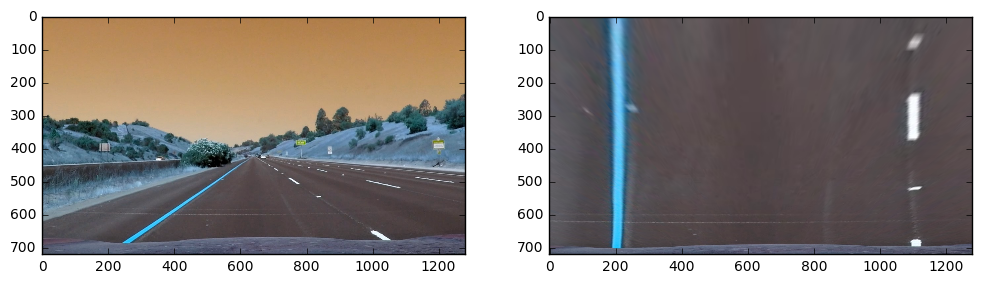

In [106]:

def warp_image(image):
    image = np.copy(image)
    warp_vertices_src = [(160, image.shape[0]), (560, 470), (720, 470), (1120, image.shape[0])]
#     color=[255, 0, 0]
#     cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 1)
#     cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 1)
#     cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 1)
    src = np.float32(warp_vertices_src)
    dst = np.float32([[160, 720], [160, 0], [1120, 0], [1120, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

image = images[0]
warped = warp_image(image)
f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(image)
ax[1].imshow(warped)

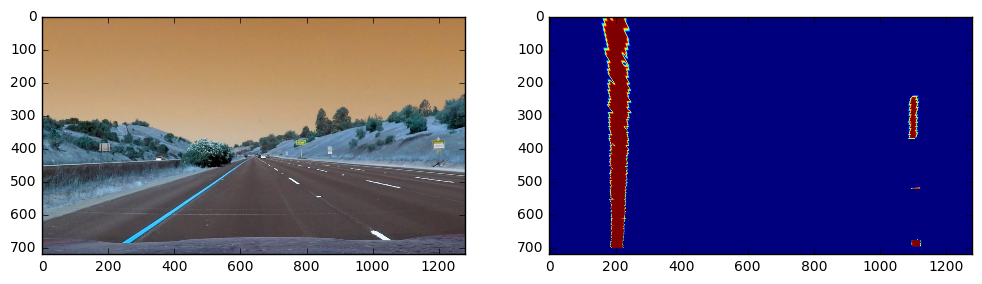

In [112]:
image = images[0]

filtered = filter_lanes(image)
warped = warp_image(filtered)

f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(image)
ax[1].imshow(warped)

C:\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


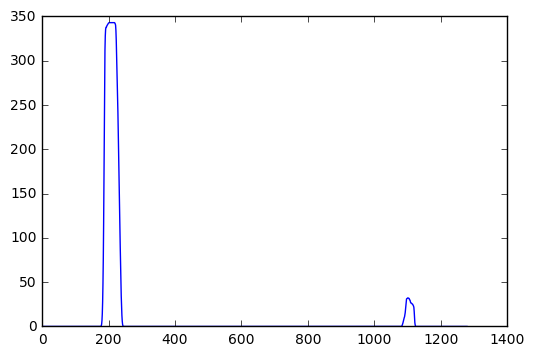

In [114]:
filtered = filter_lanes(images[0])
warped = warp_image(filtered)

histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

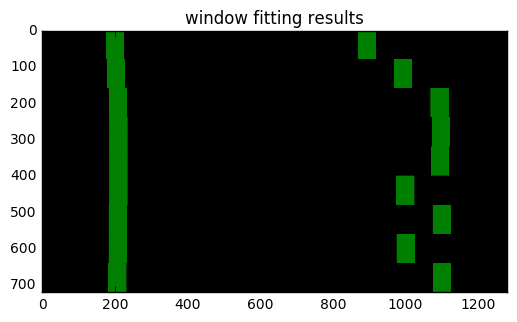

In [113]:

filtered = filter_lanes(image)
warped = warp_image(filtered)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
